In [1]:
# Install PySpark and findspark in Colab environment
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark findspark -q

import os
import findspark

# Set JAVA_HOME for this Colab session (needed by Spark)
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
findspark.init()

In [2]:
# importing all the important libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, when, randn
from pyspark.sql.types import FloatType, IntegerType

# Starting Spark with the app name "Cloud_Tech"
spark = SparkSession.builder.master("local[*]").appName("Cloud_Tech").getOrCreate()
print("Spark session started:", spark.sparkContext.appName)


Spark session started: Cloud_Tech


In [3]:
#reading both the datasets
df1=spark.read.csv("/content/mentalhealth_dataset.xls",header=True,inferSchema=True) #header = true to show the column names
df2=spark.read.csv("/content/students_mental_health_survey.xls",header=True,inferSchema=True) #inferschema to check the datatype,otherwise it is string

#taking look at the first 5 rows, .show(5)
df1.show(5)
df2.show(5)

#checking the schema and structure of both datasets
df1.printSchema()
df2.printSchema()


+---------+------+---+-------------+-----------+----+----------+-------+-----------+-------------------+--------------------------+----------------------+------------+----------------+-----------------+------------------+
|Timestamp|Gender|Age|       Course|YearOfStudy|CGPA|Depression|Anxiety|PanicAttack|SpecialistTreatment|SymptomFrequency_Last7Days|HasMentalHealthSupport|SleepQuality|StudyStressLevel|StudyHoursPerWeek|AcademicEngagement|
+---------+------+---+-------------+-----------+----+----------+-------+-----------+-------------------+--------------------------+----------------------+------------+----------------+-----------------+------------------+
|13/7/2020|Female| 24|Biotechnology|     Year 3|2.38|         1|      0|          0|                  0|                         5|                     0|           4|               5|                8|                 2|
|13/7/2020|Female| 18|Biotechnology|     Year 3| 4.0|         0|      1|          0|                  0|        

In [4]:
#drop columns not needed in the dataset
df1=df1.drop('Timestamp', 'YearOfStudy', 'PanicAttack', 'SymptomFrequency_Last7Days')

#renaming all the columns in df1 to match with df2
df1=df1.withColumnRenamed('Depression', 'Depression_Score') \
.withColumnRenamed('Anxiety', 'Anxiety_Score') \
.withColumnRenamed('SleepQuality', 'Sleep_Quality') \
.withColumnRenamed('StudyStressLevel', 'Stress_Level')

#drop irrelevant columns from df2
df2=df2.drop('Relationship_Status', 'Substance_Use', 'Family_History','Chronic_Illness', 'Extracurricular_Involvement','Residence_Type','Semester_Credit_Load')


In [5]:
#remove rows where CGPA is missing
df2=df2.na.drop(subset=['CGPA'])


In [6]:
from pyspark.sql.functions import lower, trim

#convert all course names to lowercase and remove any whitespaces
df1=df1.withColumn('Course',lower(trim(col('Course')))) # .withcolumn here replaces the values
df2=df2.withColumn('Course',lower(trim(col('Course'))))


In [7]:
#map text sleep quality to match values in df2
sleep_map={'Poor': 1, 'Average': 3, 'Good': 5}

from pyspark.sql.functions import udf # udf to apply self made like custom functions in spark
from pyspark.sql.types import IntegerType # the integer datatype , this requires seperately

map_udf=udf(lambda x: sleep_map.get(x, 3), IntegerType())  # default=3 if not found
df2=df2.withColumn('Sleep_Quality', map_udf(col('Sleep_Quality')))

#replace Stress_Level 0 with 1 to match df1
df2=df2.withColumn('Stress_Level', when(col('Stress_Level') == 0, 1).otherwise(col('Stress_Level'))) #otherwise is used if is not zero ,it keeps the original


In [8]:
#replace zeros with 1 to match df1 values
df2=df2.withColumn('Depression_Score',when(col('Depression_Score')==0, 1).otherwise(col('Depression_Score')))
df2=df2.withColumn('Anxiety_Score',when(col('Anxiety_Score')==0, 1).otherwise(col('Anxiety_Score')))


In [9]:
#convert binary scores to categorical scale 1–5
df1=df1.withColumn('Depression_Score',(col('Depression_Score')* 4+1).cast(IntegerType()))
df1=df1.withColumn('Anxiety_Score',(col('Anxiety_Score')* 4+1).cast(IntegerType()))


In [10]:
import pandas as pd
import numpy as np
import joblib # for the model

#convert df2 to Pandas to use sklearn model
df2_pd=df2.toPandas() # is only done to process the prediction part

#load pre-trained model
model= joblib.load('study_hours_model.pkl')

#Predicting study hours
df2_pd['StudyHoursPerWeek']= model.predict(df2_pd[['CGPA']])
df2_pd['StudyHoursPerWeek']+= np.random.normal(0, 0.5, len(df2_pd)) # adding randomness

# Add missing columns if not present
for col_name in ['SpecialistTreatment', 'HasMentalHealthSupport', 'AcademicEngagement']:
    if col_name not in df2_pd.columns:
        df2_pd[col_name] = 0

# Reorder df2 columns to match df1
df2_pd=df2_pd[df1.columns]

# Convert back to Spark
df2=spark.createDataFrame(df2_pd)


In [11]:
#combine both datasets into one Spark DataFrame
spark_df = df1.unionByName(df2) #it combines 2 datasets by column name and not the position

#show total rows and first few rows
print("Total rows:", spark_df.count())
spark_df.show(5)


Total rows: 8010
+------+---+-------------+----+----------------+-------------+-------------------+----------------------+-------------+------------+-----------------+------------------+
|Gender|Age|       Course|CGPA|Depression_Score|Anxiety_Score|SpecialistTreatment|HasMentalHealthSupport|Sleep_Quality|Stress_Level|StudyHoursPerWeek|AcademicEngagement|
+------+---+-------------+----+----------------+-------------+-------------------+----------------------+-------------+------------+-----------------+------------------+
|Female| 24|biotechnology|2.38|               5|            1|                  0|                     0|            4|           5|              8.0|                 2|
|Female| 18|biotechnology| 4.0|               1|            5|                  0|                     0|            4|           4|             13.0|                 5|
|Female| 25|biotechnology|3.68|               1|            1|                  0|                     0|            1|           2| 

In [12]:
#saving the merged dataset to a csv file
spark_df.coalesce(1).write.csv("final_dataset.csv", header=True)

from google.colab import files
files.download("final_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

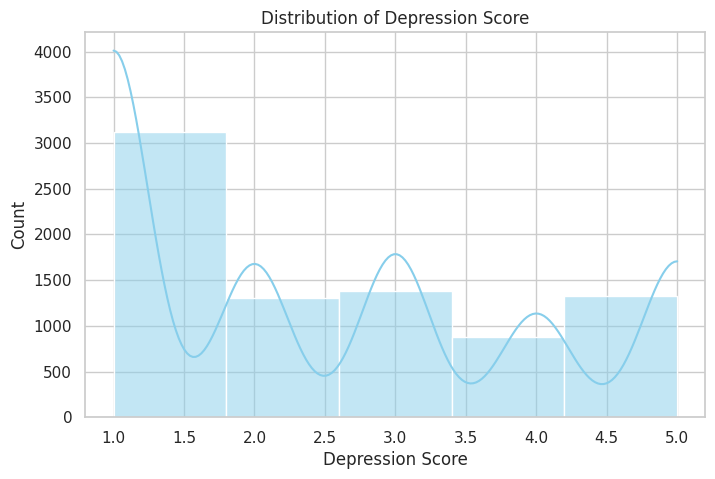

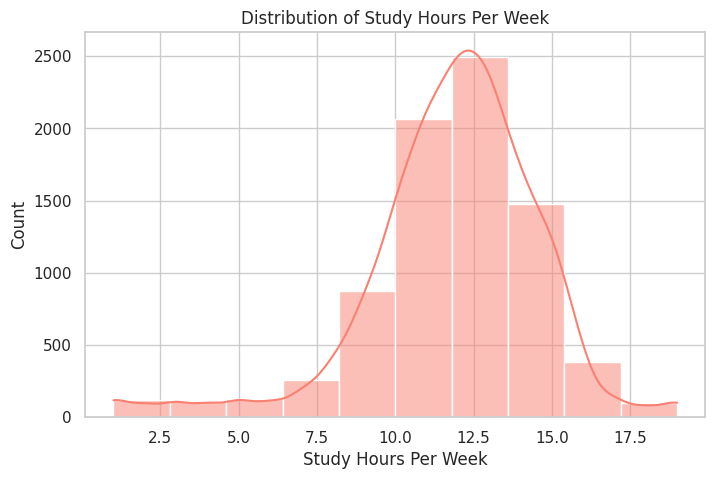

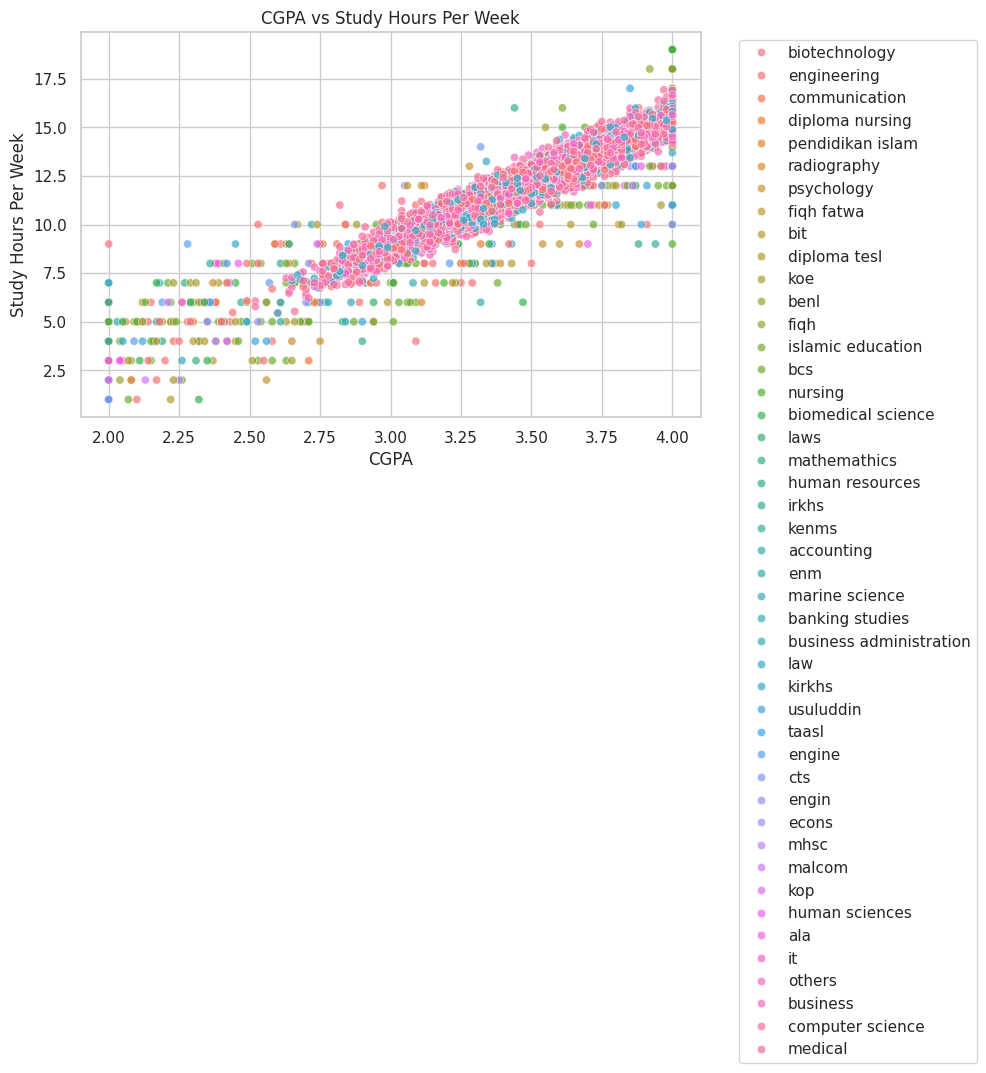

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

#convert Spark df to Pandas for visualizations
df_pd = spark_df.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
sns.histplot(df_pd['Depression_Score'], bins=5, kde=True, color='skyblue')
plt.title("Distribution of Depression Score")
plt.xlabel("Depression Score")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df_pd['StudyHoursPerWeek'], bins=10, kde=True, color='salmon')
plt.title("Distribution of Study Hours Per Week")
plt.xlabel("Study Hours Per Week")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x='CGPA', y='StudyHoursPerWeek', data=df_pd, hue='Course', alpha=0.7)
plt.title("CGPA vs Study Hours Per Week")
plt.xlabel("CGPA")
plt.ylabel("Study Hours Per Week")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
